# Agent-Environment Interaction for option-based RL with Subgoal Discovery methods  

In [1]:
""" Imports """

import numpy as np

from agent import SMDPQLearning
from core import (
    Policy,
    Option,
    RewardRespectingFeatureAttainment
)
from env import (
    TwoRooms,
    FourRooms,
    get_primitive_actions_as_options
)
from trajectory_sampler import (
    sample,
    reset
)
from option_learning import (
    actor_critic,
    to_deterministic_policy
)


In [2]:
%load_ext autoreload
%autoreload 1
%aimport empowerment
%aimport plot

## Basic experiment loop

In [3]:
""" Parameters """
num_episodes = 50  # number of episodes to run
phase_1 = 10  # time window to create the new option

## Get environment and agent

In [4]:
""" Environment setup """

# Create the environment
tworooms = TwoRooms(
    size=(10,14),
    start_states=[0],
    goal_states=[139],
    hallway_height=4,
    negative_states_config="none",
    sparse_rewards=True,
    max_steps=None
)

fourrooms = FourRooms(
    start_states=[0],
    goal_states=[99],
    negative_states_config="none",
    max_steps=None,
    sparse_rewards=True
)

env = tworooms

print("Environment:", env.__class__.__name__)

Environment: TwoRooms


In [5]:
""" Agent setup """

# Set up the agent with primitive options (actions)
primitive_options = get_primitive_actions_as_options(env)

agent = SMDPQLearning(
    env,
    primitive_options,
    learning_rate=0.1,
    discount_factor=0.99,
    exploration_rate=0.1,
    min_exploration_rate=0.1,
    exploration_decay=1,
    store_experience=True,
)

print("Agent:", agent.__class__.__name__)


Agent: SMDPQLearning


In [6]:
""" Reset """

# Reset the environment and agent
env, agent = reset(env, agent)

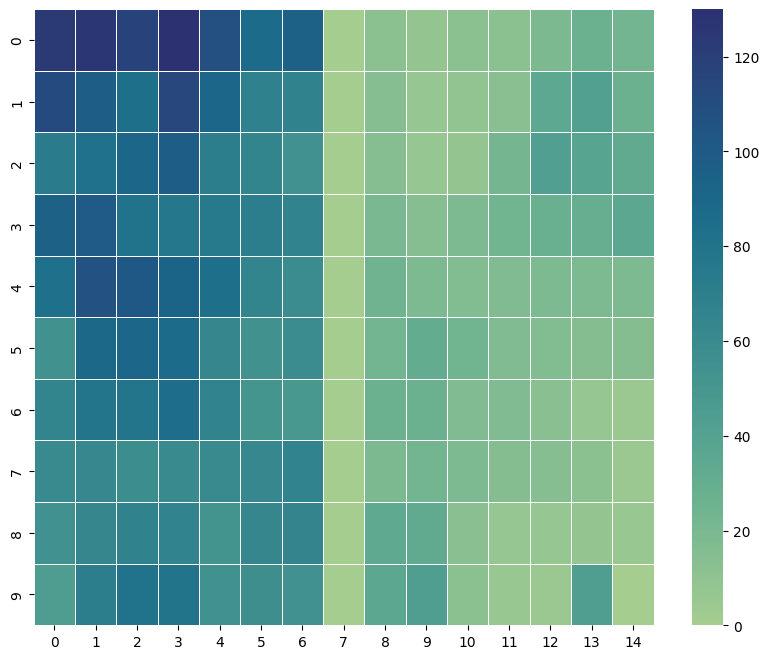

<Figure size 1200x800 with 0 Axes>

In [7]:
""" Visualize count scores"""
from plot import plot_heatmap_from_state_scores

# Sample a trajectory to visualize state visitation counts
s0, R, steps, G, t = agent.run_episode()

count = {s: 0 for s in range( env.observation_space.n )}
for s in t:
    if s == -1:
        continue
    count[s] += 1
plot_heatmap_from_state_scores(env, count, False, '')

env, agent = reset(env, agent)

## Phase 1

In [8]:
""" Simulate first stage of training """

# Number of sampled trajectories in first stage of training
print("Sampling trajectories for phase 1 of", phase_1, "episodes...", end=" ")
trajectories, results, steps, total_rewards = sample(env, agent, phase_1)
print("done.")

Sampling trajectories for phase 1 of 10 episodes... 

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

done.


## Subgoal Discovery algorithm

In [9]:
""" Import methods """
from empowerment import empowerment_subgoal_discovery
# from subgoal_discovery import diverse_density

In [10]:
""" Select subgoal discovery method and its parameters """

_methods = ["empowerment"]

method = _methods[0]  # Select the method to use

if method == "empowerment":
    # Parameters for empowerment method
    k = 3  # Number of subgoals to return
    h = 5  # time horizon for n-step empowerment calculation


print("Using method:", method)

Using method: empowerment


In [11]:
f"Collected {agent.eb.size} samples of experience in buffer"

'Collected 10194 samples of experience in buffer'

In [12]:
gs, empowerment_scores = empowerment_subgoal_discovery(
    agent.eb,
    k=k,
    n_step=h,
    return_scores=True,
    log=True
)

g = np.random.choice(gs)
f"selected subgoal {g} with empowerment of {empowerment_scores[g]}"


Collected experience in buffer 10194
Build transition matrix T of shape (140, 4, 140)
Selected 3 states with highest empowerment scores [62, 63, 139]


'selected subgoal 139 with empowerment of 5.672425341971495'

(<Figure size 1000x800 with 2 Axes>, <Axes: >)

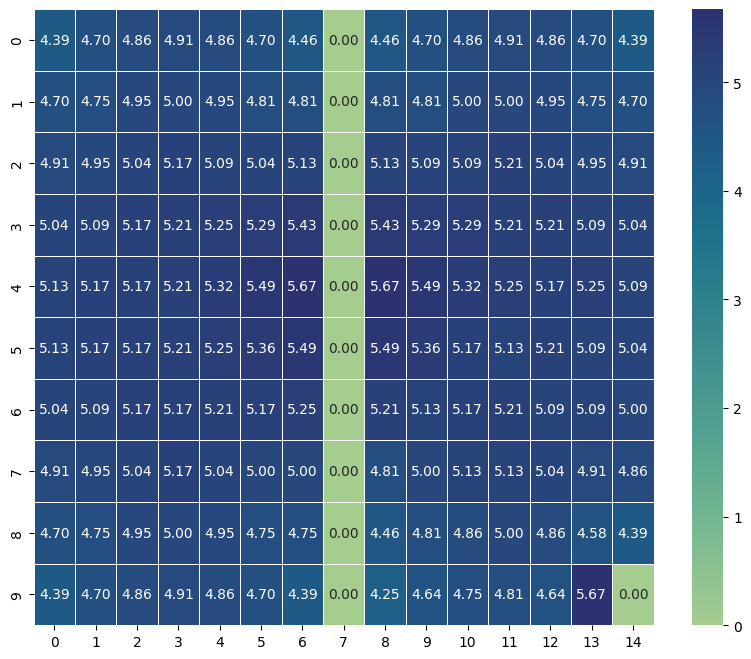

<Figure size 1200x800 with 0 Axes>

In [13]:
""" Visualize empowerment scores"""
from plot import plot_heatmap_from_state_scores

plot_heatmap_from_state_scores(env, empowerment_scores, False, '', show_scores=True)


## Option Learning

In [14]:
""" Learn an option to reach the subgoal """

# Create a reward respecting subtask with the discovered subgoal
subtask = RewardRespectingFeatureAttainment(env, feature_attainment= g)
# Learn an policy to reach the subgoal using actor-critic
w, theta = actor_critic(subtask, alpha=0.1, gamma=0.99, alpha_=0.1, number_of_steps=50000)
policy: Policy = to_deterministic_policy(env, theta)


100%|██████████| 50000/50000 [00:04<00:00, 11763.49it/s]


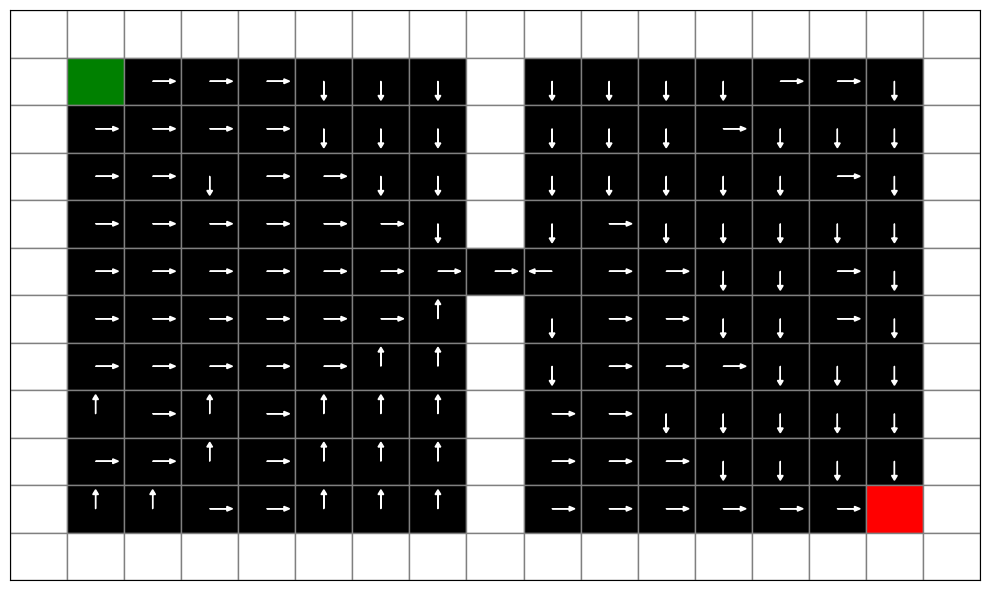

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

In [15]:
""" Visualize learned option """
from plot import plot_deterministic_policy_in_tworooms

plot_deterministic_policy_in_tworooms(env, policy, subtask.feature_attainment)


In [16]:
""" Define the option to reach the subgoal """

def termination_fn(state):
    """ Termination condition for the option """
    return state == g or state == env.goal_transition_state

option = Option(
    id=f"o1_to_subgoal_{g}",
    initiation_set=set( range(env.observation_space.n) ),
    policy=policy,
    termination=termination_fn
)

option


ID: o1_to_subgoal_139
Initiation Set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139}
Policy: {0: array([0., 0., 0., 1.]), 1: array([0., 0., 0., 1.]), 2: array([0., 0., 0., 1.]), 3: array([0., 0., 0., 1.]), 4: array([0., 1., 0., 0.]), 5: array([0., 1., 0., 0.]), 6: array([0., 1., 0., 0.]), 7: array([0., 1., 0., 0.]), 8: array([0., 1., 0., 0.]), 9: array([0., 1., 0., 0.]), 10: array([0., 1., 0., 0.]), 11: array([0., 0., 0., 1.]), 12: array([0., 0., 0., 

In [17]:
""" Add the learned option to the agent """

agent.add_option(option)
agent.options_size

5

In [18]:
""" Save the option policy, if desired """

option.save_policy("../options/tworooms_o_to_subgoal_{}.pkl".format(g))

## Phase 2

In [19]:
""" Second stage of training """

phase_2 = num_episodes - phase_1  # number of episodes in phase 2
phase_2

40

In [20]:
""" Simulate second stage of training """

# Number of sampled trajectories in first stage of training
print("Sampling trajectories for phase 2 of", phase_2, "episodes...", end=" ")
trajectories_, results_, steps_, total_rewards_ = sample(env, agent, phase_2)
print("done.")

Sampling trajectories for phase 2 of 40 episodes... 

100%|██████████| 40/40 [00:00<00:00, 162.00it/s]

done.


## Q-Learning baseline

In [21]:
primitive_options = get_primitive_actions_as_options(env)

qlearning_agent = SMDPQLearning(
    env,
    primitive_options,
    learning_rate=0.1,
    discount_factor=0.99,
    exploration_rate=0.1,
    min_exploration_rate=0.1,
    exploration_decay=1,
    store_experience=False
)

# Reset the environment and agent
env, qlearning_agent = reset(env, qlearning_agent)

print("Sampling trajectories for Q-learning baseline of", num_episodes, "episodes...", end=" ")
bl_trajectories, bl_results, bl_steps, bl_total_rewards = sample(env, qlearning_agent, num_episodes)
print("done.")

Sampling trajectories for Q-learning baseline of 50 episodes... 

100%|██████████| 50/50 [00:08<00:00,  5.90it/s]

done.


## Statistics

In [22]:
""" Combine results from both phases of training """

trajectories += trajectories_
results += results_
steps += steps_
total_rewards += total_rewards_

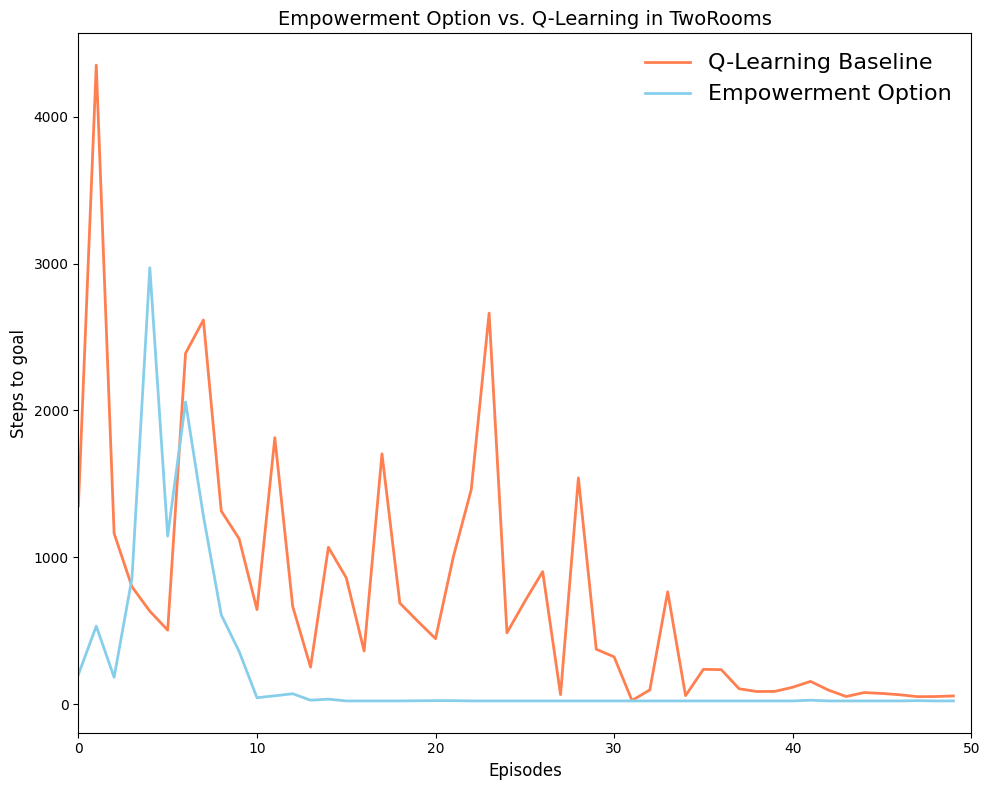

In [23]:
# Plot the results
import matplotlib.pyplot as plt

x = range(num_episodes)

fig, ax1 = plt.subplots(figsize=(10, 8))

# Primary axis (left y-axis) for subgoal discovery (red)
ax1.set_xlabel('Episodes', fontsize=12, color='black')
ax1.set_ylabel('Steps to goal', color='black', fontsize=12)

ax1.plot(x, bl_steps, color='coral', linewidth=2, label='Q-Learning Baseline')
ax1.tick_params(axis='y', labelcolor='coral')

ax1.plot(x, steps, color='skyblue', linewidth=2, label='Empowerment Option')
ax1.tick_params(axis='y', labelcolor='skyblue')

ax1.grid(False)
ax1.set_xlim(0, num_episodes)

# Add title at the top (uncomment if needed)
plt.title(f'Empowerment Option vs. Q-Learning in {env.__class__.__name__}', color='black', fontsize=14)

# Style the plot
for spine in ax1.spines.values():
    spine.set_color('black')

ax1.tick_params(colors='black')
ax1.xaxis.label.set_color('black')

plt.tight_layout()
plt.legend(loc='upper right', fontsize=16, frameon=False)
plt.show()